# Unsupervised Representation Learning With Deep Convolutional Generative Adversial Networks
* [paper](https://arxiv.org/pdf/1511.06434v2.pdf)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim


from torchvision import datasets
from torch.utils.data import DataLoader, Subset, Dataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Network

In [37]:
from typing import List

# experimented with how i created network to have more flexibility based on 
# what i've seen with other code

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int=5, 
                 stride: int=2, padding: int=2):
        super().__init__()
        self.use_batchnorm = True
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                              padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(.2)

    def forward(self, X):
        out = self.conv(X)
        if self.use_batchnorm:
            out = self.bn(out)
        out = self.act(out)
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size: int=5, stride: int=2, padding: int=2,
                 out_padding: int=1):
        super().__init__()
        self.use_batchnorm = True
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                        stride, padding, out_padding)
        self.bn = nn.BatchNorm2d(out_channels)
        # self.act = nn.ReLU()
        self.act = nn.LeakyReLU(.2)

    def forward(self, X):
        out = self.convT(X)
        if self.use_batchnorm:
            out = self.bn(out)
        out = self.act(out)
        return out

class Generator(nn.Module):
    def __init__(self, channel_sizes: List[int], z_dim: int=100,
                 img_size: int=64):
        super().__init__()
        num_samples = len(channel_sizes)-1
        # dimensions of input volume for upsampling network
        # every time downsample, img_size halves
        self.in_dim = img_size//(2**num_samples)
        # depth of input volume for upsamling network
        self.in_channels = channel_sizes[0]
        # size of input volume to upsampling network flattend
        flat_size = channel_sizes[0] * self.in_dim * self.in_dim
        up_layers = []
        for i in range(num_samples):
            up_layers.append(UpsampleBlock(channel_sizes[i],
                                           channel_sizes[i+1]))
        self.img_size = img_size
        # final layer no batchnorm and use Tanh activation
        up_layers[-1].use_batchnorm = False
        up_layers[-1].act = nn.Tanh()
        self.upsample = nn.Sequential(*up_layers)
        self.fc = nn.Sequential(
            nn.Linear(z_dim, flat_size),
            nn.ReLU()
        )

    def forward(self, z: torch.Tensor):
        out = self.fc(z)
        out = out.view(-1, self.in_channels, self.in_dim, self.in_dim)
        out = self.upsample(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, channel_sizes: List[int], img_size: int=64):
        super().__init__()
        num_samples = len(channel_sizes)-1
        # dimensions of output volume from downsampling network
        # everytime downsample, img_size halves
        out_dim = img_size//(2**num_samples)
        # depth of output volume from downsampling network
        out_channels = channel_sizes[-1]
        # size of output volume from downsampling network flattend
        flat_size = out_channels * out_dim * out_dim
        down_layers = []
        for i in range(num_samples):
            down_layers.append(DownsampleBlock(channel_sizes[i],
                                               channel_sizes[i+1]))
        # no batchnorm on input layer
        down_layers[0].use_batchnorm = False
        self.downsample = nn.Sequential(*down_layers)
        self.fc = nn.Sequential(
            nn.Linear(flat_size, 1),
            nn.Sigmoid()
        )

    def forward(self, X: torch.Tensor):
        out = self.downsample(X)
        out = torch.flatten(out, 1, 3)
        out = self.fc(out)
        return out

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Getting Data

In [4]:
# FGVC-Aircraft Dataset

img_size = (64, 64)
ts = [T.ToTensor(), T.Resize(img_size)]
train = datasets.FGVCAircraft(
    root='data',
    split='train',
    download=True,
    transform=T.Compose(ts) 
)

test = datasets.FGVCAircraft(
    root='data',
    split='test',
    download=True,
    transform=T.Compose(ts)
)



  0%|          | 0/2753340328 [00:00<?, ?it/s]

Extracting data/fgvc-aircraft-2013b.tar.gz to data


# Training

In [49]:
dis_fake_loss = []
dis_real_loss = []
gen_loss = []

In [48]:
from tqdm import tqdm

def train_gen(gen: nn.Module, dis: nn.Module, bs: int, z_dim: int, 
              loss: nn.Module, opt: torch.optim.Optimizer):
    opt.zero_grad()
    z = torch.randn((bs, z_dim)).to(DEVICE)
    gen_z = gen(z)
    dis_z = dis(gen_z)
    loss_gen = loss(dis_z, torch.full_like(dis_z, 0.9))
    loss_gen.backward()
    opt.step()
    return loss_gen

def train_dis(gen: nn.Module, dis: nn.Module, batch: torch.Tensor,
              z_dim: int, loss: nn.Module, opt: torch.optim.Optimizer):
    opt.zero_grad()
    z = torch.randn((batch.shape[0], z_dim)).to(DEVICE)
    gen_z = gen(z).detach()
    dis_z = dis(gen_z)
    loss_fake = loss(dis_z, torch.full_like(dis_z, 0.1))
    dis_x = dis(batch)
    loss_real = loss(dis_x, torch.full_like(dis_x, 0.9))
    
    loss_total = loss_fake + loss_real
    loss_total.backward()
    opt.step()
    
    return  loss_fake, loss_real


def train_model(gen: nn.Module, dis: nn.Module, fixed: torch.Tensor, 
                train_data: Dataset, epochs: int, bs: int=64, lr: float=1e-3,
                beta_1: float=.5, beta_2=.999, z_dim: int=100):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    opt_gen = optim.Adam(gen.parameters(), betas=(beta_1, beta_1), lr=lr)
    opt_dis = optim.Adam(dis.parameters(), betas=(beta_1, beta_2), lr=lr)
    
    bce = nn.BCELoss()
    m = 1
    n = 2

    for i in tqdm(range(epochs)):
        gen.train()
        dis.train()
        for j, (X,_) in enumerate(train_loader):
            X = X.to(DEVICE)
            batch_size = X.shape[0]
            # train discriminator
            for _ in range(m):
                losses = train_dis(gen, dis, X, z_dim, bce, opt_dis)
                loss_dis_fake, loss_dis_real = losses
                dis_fake_loss.append(loss_dis_fake.detach().cpu())
                dis_real_loss.append(loss_dis_real.detach().cpu())
            # train generator
            for _ in range(n):
                loss_gen = train_gen(gen, dis, X.shape[0], z_dim, bce, 
                                     opt_gen)
                gen_loss.append(loss_gen.detach().cpu())
        if i % 5:
            gen.eval()
            out = gen(fixed).detach().cpu()
            img = T.ToPILImage()(out.view(3, 64, 64))
            display(img)

In [50]:
channel_sizes = [3, 128, 256, 512, 1024]
z_dim = 100

data = train
subset_size = 1000
use_subset = True
if use_subset:
    data = Subset(train, range(subset_size))

gen = Generator(channel_sizes=channel_sizes[::-1]).to(DEVICE)
# gen.apply(weights_init)
dis = Discriminator(channel_sizes=channel_sizes).to(DEVICE)
# dis.apply(weights_init)

In [51]:
fixed = torch.randn([1, z_dim]).to(DEVICE)

In [52]:
EPOCHS = 10
BS = 64
BETA_1 = 0.5
BETA_2 = 0.999
LR = 1e-4

 10%|█         | 1/10 [00:36<05:24, 36.04s/it]

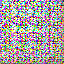

 20%|██        | 2/10 [01:10<04:41, 35.16s/it]

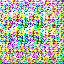

 30%|███       | 3/10 [01:45<04:05, 35.11s/it]

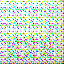

 40%|████      | 4/10 [02:20<03:30, 35.14s/it]

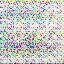

 60%|██████    | 6/10 [03:29<02:18, 34.72s/it]

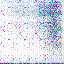

 70%|███████   | 7/10 [04:04<01:43, 34.62s/it]

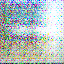

 80%|████████  | 8/10 [04:38<01:09, 34.55s/it]

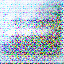

 90%|█████████ | 9/10 [05:13<00:34, 34.64s/it]

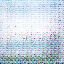

100%|██████████| 10/10 [05:47<00:00, 34.76s/it]


In [53]:
train_model(gen, dis, fixed, data, epochs=EPOCHS, bs=BS, lr=LR, beta_1=BETA_1, beta_2=BETA_2, z_dim=z_dim)

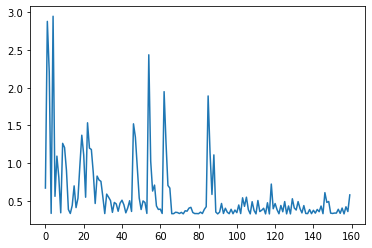

In [55]:
import matplotlib.pyplot as plt
plt.plot(dis_fake_loss)

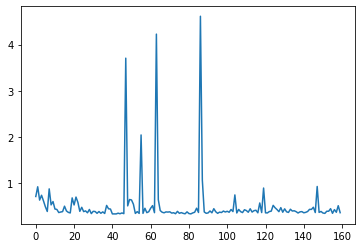

In [56]:
plt.plot(dis_real_loss)

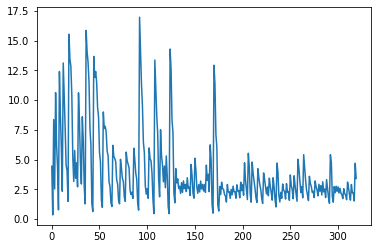

In [57]:
plt.plot(gen_loss)

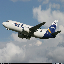

real 0.21389253169763833
gen tensor(0.2080, device='cuda:0', grad_fn=<MeanBackward0>)


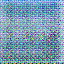

In [54]:
to_img = T.ToPILImage()

real_img = to_img(train[100][0])
display(real_img)

gen.eval()
dis.eval()

out = gen(torch.rand((64, 100)).to(DEVICE)).detach()

mean = 0
for i in Subset(train, range(64)):
    a = dis(i[0].view(-1, 3, 64, 64).to(DEVICE)).detach().item()
    mean += a
    
mean /= 64
print('real', mean)
print('gen', dis(out).view(64).mean())
gen_img = to_img(out[0].view(-1, 64, 64))
display(gen_img)
# dis(out)